### Backtesting
- 구현한 모델을 통한 수익률 예측
- 구현 날짜: 2024.03.11
- 딥러닝 적용 
- 고려사항: num_rows 값에 의해 없어진 sequence 같은거 계산 어떻게 해야하지..?

In [1]:
# 필요 라이브러리 import

# Pytorch
import torch
import torch.optim as optim
import torch.nn as nn

# Dataset 관련
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import sequence as sq # 사용자 정의 함수 불러오기

# 성능 평가 관련
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from collections import Counter

# Visualization 관련
import matplotlib.pyplot as plt
import seaborn as sns

# 하이퍼파라미터 튜닝
import optuna
from optuna.pruners import MedianPruner
from sklearn.model_selection import TimeSeriesSplit

# 운영체제 관련
import platform

'''
딥러닝 학습을 진행할 때, 가중치를 임의의 값으로 초기화하여 학습을 수행하는 데, 
실험을 동일하게 진행하기 위해서는 난수를 동일하게 생성해야 한다.
Pytorch에서 random seed를 고정하기 위해 manual_seed를 사용한다.
'''

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# 운영체제별 device 설정
os_name = platform.system()
if os_name == 'Windows':
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"이 PC는 윈도우 운영 체제입니다. {device} is available")
elif os_name == 'Darwin':
    device = torch.device("mps" if torch.backends.mps.is_available else "cpu")
    print(f"이 PC는 맥(OS X) 운영 체제입니다. {device} is available")
else:
    print(f"이 PC는 다른 운영 체제입니다: {os_name}")


이 PC는 맥(OS X) 운영 체제입니다. mps is available


/opt/homebrew/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
# 데이터 불러오기
file_path = '../../data/' # 경로 설정
df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_5.csv')
df = df.iloc[:50000]
df['returns_next10m_binary'] = df['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 종속변수 이진분류화
df = df.reset_index()
df = df.sort_values(by='window_start', ascending=True) # 시간순 정렬
df

,index,window_start,window_end,num_rows,lowest_return,highest_return,high_low_gap,trade_vol,volume_power,beginning_price,...,ob_end_bias_0,ob_end_bias_1,ob_end_bias_4,ob_end_bidask_spread,ob_end_liq_0,ob_end_liq_1,ob_end_liq_4,highest_possible_return,del_idx,returns_next10m_binary
0,0,2022-12-16 21:05:30,2022-12-16 21:06:00,14,0.000000,0.000089,0.000089,1.468656,0.747351,22568000.0,...,5.470422,10.649683,3.235541,2.0,0.001693,0.002198,0.002412,1.000000,0,0
1,1,2022-12-16 21:06:00,2022-12-16 21:06:30,10,0.000000,0.000089,0.000089,0.567585,0.027857,22568000.0,...,4.224361,14.918538,3.856600,2.0,0.000531,0.001064,0.001471,1.000000,0,0
2,2,2022-12-16 21:06:30,2022-12-16 21:07:00,24,-0.000576,0.000044,0.000620,1.677093,0.146635,22570000.0,...,17.677511,9.697905,1.106227,14.0,0.000449,0.000536,0.001821,0.999778,0,0
3,3,2022-12-16 21:07:00,2022-12-16 21:07:30,22,-0.000044,0.000443,0.000488,2.439677,0.751995,22557000.0,...,95.630870,3.371113,1.367349,2.0,0.000416,0.000480,0.001422,0.999911,0,0
4,4,2022-12-16 21:07:30,2022-12-16 21:08:00,24,-0.000443,0.000000,0.000443,2.345821,-0.915608,22565000.0,...,0.114815,0.828364,0.068175,10.0,0.000311,0.000560,0.003454,0.999911,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,2023-01-09 20:08:30,2023-01-09 20:09:00,56,-0.000092,0.000138,0.000229,1.263864,0.105912,21790000.0,...,0.778812,0.708353,0.809834,1.0,0.000259,0.001217,0.002863,1.000275,0,1
49996,49996,2023-01-09 20:09:00,2023-01-09 20:09:30,33,0.000000,0.000092,0.000092,1.437709,-0.263192,21792000.0,...,0.918841,5.020701,0.837299,1.0,0.002382,0.004253,0.005242,1.000230,0,0
49997,49997,2023-01-09 20:09:30,2023-01-09 20:10:00,94,0.000000,0.000092,0.000092,4.365295,0.649645,21794000.0,...,0.047378,0.270408,2.139321,1.0,0.004324,0.005156,0.008199,1.000138,0,0
49998,49998,2023-01-09 20:10:00,2023-01-09 20:10:30,44,0.000000,0.000092,0.000092,1.528870,0.535182,21795000.0,...,0.478380,6.393976,2.729303,1.0,0.000722,0.002159,0.006489,1.000046,0,0


In [55]:
# 데이터 불러오기
file_path = '../../data/' # 경로 설정
df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_5.csv')
df = df.iloc[:50000]
df['returns_next10m_binary'] = df['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 종속변수 이진분류화
df = df.sort_values(by='window_start', ascending=True) # 시간순 정렬

target_var = df[['returns', 'returns_next10m', 'returns_next10m_binary', 'realized_vol_next10m']] # 종속변수
df.drop(columns=['returns', 'returns_next10m', 'returns_next10m_binary', 'realized_vol_next10m'], inplace=True) # 독립변수

X = df.drop(columns=['window_start', 'window_end', 'num_rows', 'time_id']) # 위 변수를 제외한 모든 변수
y = target_var['returns_next10m_binary'].values # 종속변수

In [10]:
# 데이터 불러오기
file_path = '../../data/' # 경로 설정
df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_5.csv')
df = df.iloc[:50000]
df['returns_next10m'] = df['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 종속변수 이진분류화
df = df.sort_values(by='window_start', ascending=True) # 시간순 정렬
df = df.reset_index() # backtesting을 위한 index 값 생성

# sequence length를 기준으로 sequence 데이터 생성
seq_len = 20 # 20, 40, 80, 160, 320
X, y = sq.create_sequence(df, seq_len=seq_len) # 사용자 정의 함수
# Tensor화
X_torch = torch.FloatTensor(X).to(device)
y_torch = torch.FloatTensor(y).to(device)
print('Full Data Size:', X_torch.size(), y_torch.size())

# split (80% / 20%)
train_split = int((X_torch.size(0)) * 0.8)

X_train_seq = X_torch[:train_split]
X_test_seq = X_torch[train_split:]
y_train_seq = y_torch[:train_split]
y_test_seq = y_torch[train_split:]

print('Train Size:', X_train_seq.size(), y_train_seq.size())
print('Test Size:', X_test_seq.size(), y_test_seq.size())


Full Data Size: torch.Size([21387, 20, 77]) torch.Size([21387, 1])
Train Size: torch.Size([17109, 20, 77]) torch.Size([17109, 1])
Test Size: torch.Size([4278, 20, 77]) torch.Size([4278, 1])


In [3]:
# Dataset과 DataLoader를 이용해 배치 데이터로 만든다.
train = torch.utils.data.TensorDataset(X_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(X_test_seq, y_test_seq)
batch_size = 128 # 32, 64, 128
train_loader =  torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False, drop_last=True) # 시계열 데이터기에 shuffle X, 마지막 batch 버림
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)


In [4]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CNNLSTMModel, self).__init__()
        
        # CNN 레이어
        '''
        in_channels = 일반적인 이미지와 같은 2D 데이터를 다룰 때는 특성 맵(channel)을 채널로 인식함.
        그러나 주식 시계열 데이터와 같은 1D 데이터의 경우 시퀀스 길이에 해당하는 차원이 채널로 간주됨.
        이에 따라 'in_channels'에는 시퀀스 길이를 입력해야 함.
        즉, 주식 시게열 데이터에서는 'in_channels'에는 시퀀스의 길이가 들어가야 올바르게 수행됨.
        '''
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        # LSTM 레이어
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes) # Fully Connected 레이어
        
    def forward(self, x):
        # CNN 레이어 적용 (cnn takes input of shape (batch_size, channels, seq_len))
        x = x.permute(0, 2, 1)
        out = self.cnn(x)
        
        # LSTM 레이어 적용
        '''
        LSTM 레이어에 입력을 전달하고, LSTM의 출력과 은닉 상태를 받는 부분
        x.permute(0, 2, 1): 입력텐서 x의 차원을 변경. 일반적으로 LSTM 레이어는 시간 단계(seq_len)를 두 번쨰 차원으로 받지만,
        Conv1d 레이어의 출력은 시간 단계가 세번째 차원에 위치함. 따라서 permute를 통해 차원을 변경하여 LSTM 레이어에 올바른 형태의 입력을 제공
        여기서 0번째 차원은 배치 크기(batch_size)를 나타내며, 1번째 차원은 특성 수(num_features)를 나타냄. 마지막(2번째) 차원은 시간 단계(seq_len)를 나타냄
        self.lstm(x.permute(0, 2, 1)): 변경된 입력을 LSTM 레이어에 전달함. LSTM 입력으로 3D 텐서를 받으며,
        이 텐서는 배치 크기(batch_size), 시간 단계(seq_len),. 특성 수(num_features)의 형태를 가짐
        lstm_out, _: LSTM 레이어의 출력과 은닉 상태를 받음. 여기서 은닉 상태는 사용하지 않기 때문에 '_'로 무시. lstm_out은 LSTM 레이어의 출력으로, 각 시간 단계에
        해당하는 출력을 포함하는 3D 텐서임.
        '''
        # lstm takes input of shape (batch_size, seq_len, input_size)
        out = out.permute(0, 2, 1)
        out, _ = self.lstm(out)
        
        # Fully Connected 레이어에 입력
        '''
        lstm_out[:, -1, :]: LSTM 레이어의 출력에서 마지막 시간 단계의 출력만 선택. 이는 시퀀스 예측을 위해 마지막 시간 단계의 정보만을 사용하고자 하는 것
        따라서 [:, -1, :]는 모든 배치와 모든 특성을 유지하면서 마지막 시간 단계의 출력을 선택함
        self.fc(lstm_out[:, -1, :]): 선택된 마지막 시간 단계의 출력을 Fully Connected(FC) 레이어에 입력함. FC 레이어는 입력된 LSTM 출력을 받아서 최종
        예측을 수행하는 역할을 함. 출력 크기는 1이며, 이는 주어진 입력에 대한 예측된 결과를 나타냄.
        '''
        out = self.fc(out[:, -1, :]) 
        return out

#model = CNNLSTMModel(input_size=77, hidden_size=64, num_layers=2, num_classes=1)
model = CNNLSTMModel(input_size=77, hidden_size=128, num_layers=2, num_classes=1)
model.to(device) # GPU 사용 시

CNNLSTMModel(
  (cnn): Sequential(
    (0): Conv1d(77, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [8]:
'''
학습2: train data만 가지고 학습
이미 학습1 코드에서 모델이 학습을 수행하였으므로
학습2 코드 실행 전 재시작 -> 학습1 코드 실행 X -> 학습2 코드 실행(정해진 epochs만 학습)
'''

# 손실 함수와 옵티마이저 정의
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20 # train, valid loss를 ㄴ기준으로 과적합되기 전 epochs

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch_features, batch_targets in train_loader:
        # 배치를 GPU로 전송
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
        
        # 모델에 대한 순전파 및 손실 계산
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_targets)
        
        # 역전파 및 최적화
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # 에폭마다 손실 출력
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}')


Epoch 1/20, Loss: 92.20396113395691
Epoch 2/20, Loss: 92.22856956720352
Epoch 3/20, Loss: 92.20054817199707
Epoch 4/20, Loss: 92.16955500841141
Epoch 5/20, Loss: 92.15763902664185
Epoch 6/20, Loss: 92.15091806650162
Epoch 7/20, Loss: 92.14624887704849
Epoch 8/20, Loss: 92.14341032505035
Epoch 9/20, Loss: 92.14077013731003
Epoch 10/20, Loss: 92.13950675725937
Epoch 11/20, Loss: 92.13754481077194
Epoch 12/20, Loss: 92.12523400783539
Epoch 13/20, Loss: 92.16342377662659
Epoch 14/20, Loss: 92.13303089141846
Epoch 15/20, Loss: 92.13010001182556
Epoch 16/20, Loss: 92.12974494695663
Epoch 17/20, Loss: 92.12851172685623
Epoch 18/20, Loss: 92.12782227993011
Epoch 19/20, Loss: 92.12772864103317
Epoch 20/20, Loss: 92.12807589769363


Data Imbalance: Counter({0.0: 2177, 1.0: 2101})
Accuracy: 0.5089
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/opt/homebrew/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


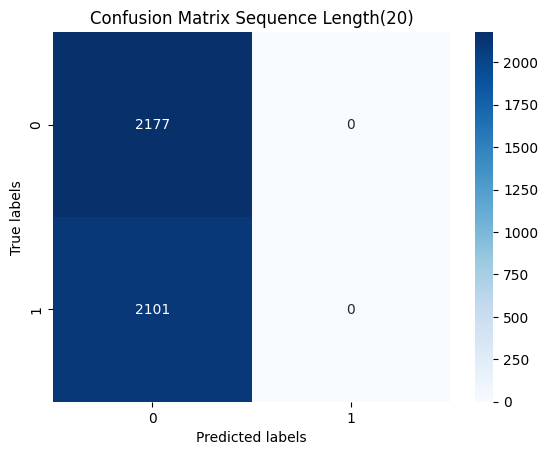

In [9]:
# 테스트 데이터 예측
model.eval()  # 모델을 평가 모드로 설정
y_true = []
y_pred = []
with torch.no_grad():
    for x_batch, labels in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)

        # 로그 오즈를 확률로 변환
        probs = torch.sigmoid(outputs).squeeze()

        # 확률을 기준으로 0.5 이상이면 1, 미만이면 0으로 예측
        preds = torch.round(probs).cpu().numpy()
        y_true.extend(labels.squeeze().cpu().numpy())
        y_pred.extend(preds)

# 성능 지표 계산
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# 결과 출력
print(f'Data Imbalance: {Counter(y_true)}')
print(f'Accuracy: {accuracy.round(4)}')
print(f'Precision: {precision.round(4)}')
print(f'Recall: {recall.round(4)}')
print(f'F1 Score: {f1.round(4)}')

# 혼동 행렬 출력
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix Sequence Length({seq_len})')
plt.show()

In [140]:
# 백테스팅
transaction_fee = 0.005 / 100
returns = target_var[['returns_next10m', 'returns_next10m_binary']][split:] # test 실제 수익률
returns['pred'] = pred1 # 모델의 binary 예측값

# 거래 시뮬레이션: 예측이 1이면 구매하고, 아니면 거래하지 않음
simulated_returns = returns[returns['pred'] == 1]['returns_next10m'] - transaction_fee
total_return = simulated_returns.sum() # 총 수익
initial_investment = len(simulated_returns) # 투자 횟수
final_portfolio_value = initial_investment + total_return # 최종 포트폴리오 가치

print(f"초기 투자 횟수: {initial_investment}")
print(f"총 수익: {total_return.round(4)}")
print(f"수익률: {(total_return / initial_investment * 100).round(4)}%")

초기 투자 횟수: 4427
총 수익: 1.663
수익률: 0.0376%


(20, 77)

In [22]:
pd.DataFrame(X)

ValueError: Must pass 2-d input. shape=(21387, 20, 77)

In [19]:
y[train_split:]

array([[0.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

numpy.ndarray